# Data Parameters
Input

- Frames: 5 in 5 out
- Target: 15 stations
- Channels: AirNow + Wind U + V

Model
- Classic

Result

General Notes
- Testing with batch norm layers

In [1]:
# file locations
import sys
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz") # for libs.plotting
model_checkpoint_file = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/basic_experiments/model.keras'
data_path = "/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/final_input_data/two_years_sat_data/"

# Data parameters
START_DATE = "2023-12-01-00"
END_DATE = "2025-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

In [3]:
'''
X_test_files =  ["AirNow_PM25_X_test.npy",  "GOES_AOD_X_test.npy",  "METAR_Wind_U_X_test.npy",  "METAR_Wind_V_X_test.npy" ]
X_train_files = ["AirNow_PM25_X_train.npy", "GOES_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "GOES_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy",  "METAR_Wind_U_X_test.npy",  "METAR_Wind_V_X_test.npy" ]
X_train_files = ["AirNow_PM25_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method. You'd need to trim the sensor data and save it first.
BATCH_SIZE = 32
X_training_files_paths = [f"{data_path + file}" for file in X_train_files]
Y_training_files_paths = f"{data_path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [5]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4, Compton = 5
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 
    'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 
    'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Temecula (Lake Skinner)', 
    'Crestline - Lake Gregory', 'Fontana - Arrow Highway'
]
sensor = {location : i for i, location in enumerate(sensors)}
sensor_names = sensors

# for some reason, the last sensor is named 'N/A'; I'll just exclude it.
Y_train = Y_train[:, :, :len(sensors)].copy()
Y_test = Y_test[:, :, :len(sensors)].copy()
Y_valid = Y_valid[:, :, :len(sensors)].copy()

# Model Definition

## Architecture

In [6]:
output_frames, output_stations = Y_train.shape[1:]
input_shape = X_train.shape[1:] # (frames, height, width, channels)

print(
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 5, 15)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 5, 15)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 5, 15)

Input shape:   (5, 40, 40, 3)
Output shape:  (5, 15)



In [7]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed, Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
        filters=15, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(BatchNormalization())

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(BatchNormalization())

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

#seq.add(TimeDistributed(Flatten()))
seq.add(Flatten())

#seq.add(Dropout(rate=0.1))

seq.add(Dense(output_stations * output_frames, activation='relu'))

seq.add(Reshape((output_frames, output_stations)))

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004)
)
seq.summary()

2025-08-12 13:28:19.868319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 13:28:19.876618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755030499.888070   24634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755030499.891769   24634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-12 13:28:19.902966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 40, 40, 15)  │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 40, 40, 30)  │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75)             │       600,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 15)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 671,326 (2.56 MB)

 Trainable params: 671,236 (2.56 MB)

 Non-trainable params: 90 (360.00 B)

## Callbacks

In [8]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    #early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [9]:
history = seq.fit(
    x=X_train,
    y=Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1755030505.394991   24707 service.cc:148] XLA service 0x7aca9c009680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755030505.395025   24707 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-08-12 13:28:25.466690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755030505.799677   24707 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-08-12 13:28:26.293512: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

  3/384 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 10.0289

I0000 00:00:1755030508.661054   24707 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.2838

2025-08-12 13:28:50.495046: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-12 13:28:50.621366: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 4.2815

2025-08-12 13:28:55.184029: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-12 13:28:55.226651: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - loss: 4.2793 - val_loss: 3.7359
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.8642 - val_loss: 3.0884
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.6499 - val_loss: 2.8294
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.5296 - val_loss: 2.7349
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.4331 - val_loss: 2.6798
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.3855 - val_loss: 2.6882
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 2.3389 - val_loss: 2.6093
Epoch 8/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.3374 - val_loss: 2.6127
Epoch 9/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.3143 - val_loss: 2.5913
Epoch 10/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.2790 - val_loss: 2.5699
Epoch 11/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.2787 - val_loss: 2.5616
Epoch 12/100
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-08-12 14:05:36.878797: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-12 14:05:36.920384: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

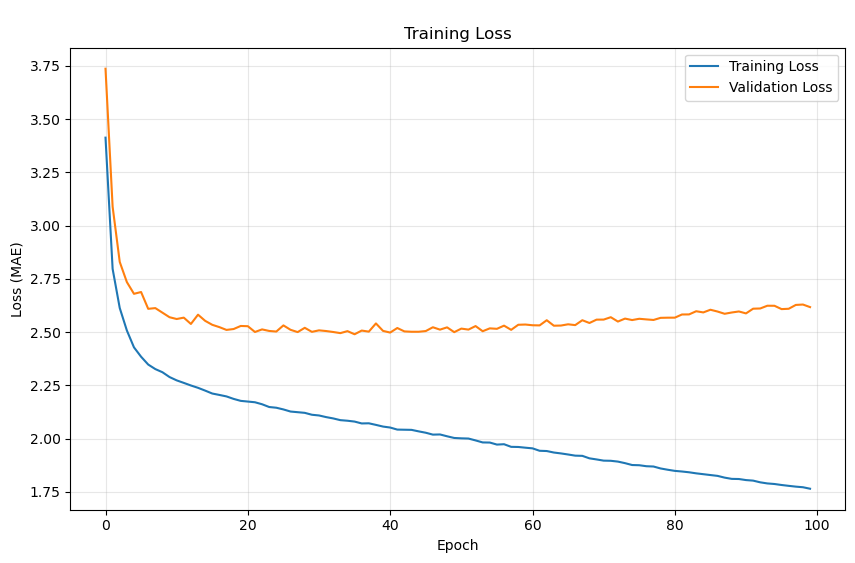

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = seq.predict(X_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
print(Y_test.shape, y_pred.shape)

(2631, 5, 15) (2631, 5, 15)


In [12]:
from libs.plotting import *
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as mape

# avg error of each station across all frames
print("Average error over each station")
results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        mape(Y_test[:-1].flatten(), Y_test[1:].flatten())*100,
        mape(Y_test.flatten(), y_pred.flatten())*100,
        mape(Y_test[:-1].flatten(), y_pred[1:].flatten())*100,
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

Average error over each station


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.713906,2.664283,2.437262
NRMSE,17.177206,26.700220,24.426866
MAE,1.169193,1.946797,1.752345
MAPE,16.305232,27.618286,24.976608
R2,0.860824,0.663641,0.718555


In [13]:
# avg pm2.5 over the entire area vs avg prediction over entire area
# basically all stations merged into 1 value instead of average error on each particular station
# difference with above: calculate errors of each station, THEN average VS calculate average PM2.5, THEN calculate error
y_pred_avg = np.mean(y_pred, axis=-1)
Y_test_avg = np.mean(Y_test, axis=-1)

print("Error of average prediction across all sensors")
results = [
    [
        rmse(Y_test_avg[1:], Y_test_avg[:-1]), 
        rmse(y_pred_avg, Y_test_avg),
        rmse(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        nrmse(Y_test_avg[1:], Y_test_avg[:-1]),
        nrmse(y_pred_avg, Y_test_avg),        
        nrmse(y_pred_avg[1:], Y_test_avg[:-1]),

    ],
    [        
        mae(Y_test_avg[1:], Y_test_avg[:-1]),
        mae(y_pred_avg, Y_test_avg),
        mae(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        mape(Y_test_avg[:-1].flatten(), Y_test_avg[1:].flatten())*100,
        mape(Y_test_avg.flatten(), y_pred_avg.flatten())*100,
        mape(Y_test_avg[:-1].flatten(), y_pred_avg[1:].flatten())*100,
    ],
    [
        r2_score(Y_test_avg[:-1], Y_test_avg[1:]),
        r2_score(Y_test_avg, y_pred_avg),
        r2_score(Y_test_avg[:-1], y_pred_avg[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

Error of average prediction across all sensors


,Baseline Error,Model Error,Model Error Shifted
RMSE,0.663332,1.261592,1.145192
NRMSE,6.648089,12.643093,11.477409
MAE,0.453196,0.905056,0.822144
MAPE,4.689219,9.459867,8.610452
R2,0.956076,0.841082,0.869082


In [14]:
# first-frame error
print("First-frame prediction error")
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(Y_test[1:, 0]))*100,
        mape(np.squeeze(Y_test[:, 0]), np.squeeze(y_pred[:, 0]))*100,
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(y_pred[1:, 0]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

First-frame prediction error


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.713698,1.808388,1.262828
NRMSE,17.176482,18.123465,12.657388
MAE,1.168970,1.271082,0.915716
MAPE,16.304691,17.292023,12.487228
R2,0.860824,0.845034,0.924424


In [15]:
# first frame LA error
print("First-frame prediction error for the LA sensor")
results = [
    [
        rmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]), 
        rmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        rmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        nrmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        nrmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),        
        nrmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),

    ],
    [        
        mae(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        mae(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        mae(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(Y_test[1:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:, 0, 4]), np.squeeze(y_pred[:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(y_pred[1:, 0, 4]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0, 4], Y_test[1:, 0, 4]),
        r2_score(Y_test[:, 0, 4], y_pred[:, 0, 4]),
        r2_score(Y_test[:-1, 0, 4], y_pred[1:, 0, 4]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

First-frame prediction error for the LA sensor


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.655120,1.816339,1.330602
NRMSE,14.034266,15.400447,11.282579
MAE,1.094682,1.258742,0.966928
MAPE,10.432978,11.658715,8.959536
R2,0.892911,0.870989,0.930788


In [16]:
# first frame, error breakdown for every sensor, nrmse
print("First frame error for each sensor")
results = [
    *[
        [
            nrmse(Y_test[1:, 0, i], Y_test[:-1, 0, i]),
            nrmse(y_pred[:, 0, i], Y_test[:, 0, i]),
            nrmse(y_pred[1:, 0, i], Y_test[:-1, 0, i])
        ]
        for i in range(len(sensor_names))
    ]
]
df = pd.DataFrame(
    results, 
    columns=['Baseline NRMSE', 'Model NRMSE', 'Model NRMSE Shifted'], 
    index=sensor_names
)
display(df)

First frame error for each sensor


,Baseline NRMSE,Model NRMSE,Model NRMSE Shifted
Simi Valley - Cochran Street,15.005320,17.206698,11.611373
Reseda,17.485002,17.288204,11.124432
Santa Clarita,14.758760,14.682009,9.320648
North Holywood,15.149515,15.240072,10.352187
Los Angeles - N. Main Street,14.034266,15.400447,11.282579
Compton,14.630370,15.470328,10.772201
Long Beach Signal Hill,21.038773,21.863485,13.746067
Anaheim,15.546726,19.091132,15.195929
Glendora - Laurel,17.270762,18.125688,12.556344
Mira Loma - Van Buren,16.423802,20.166603,15.450234


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



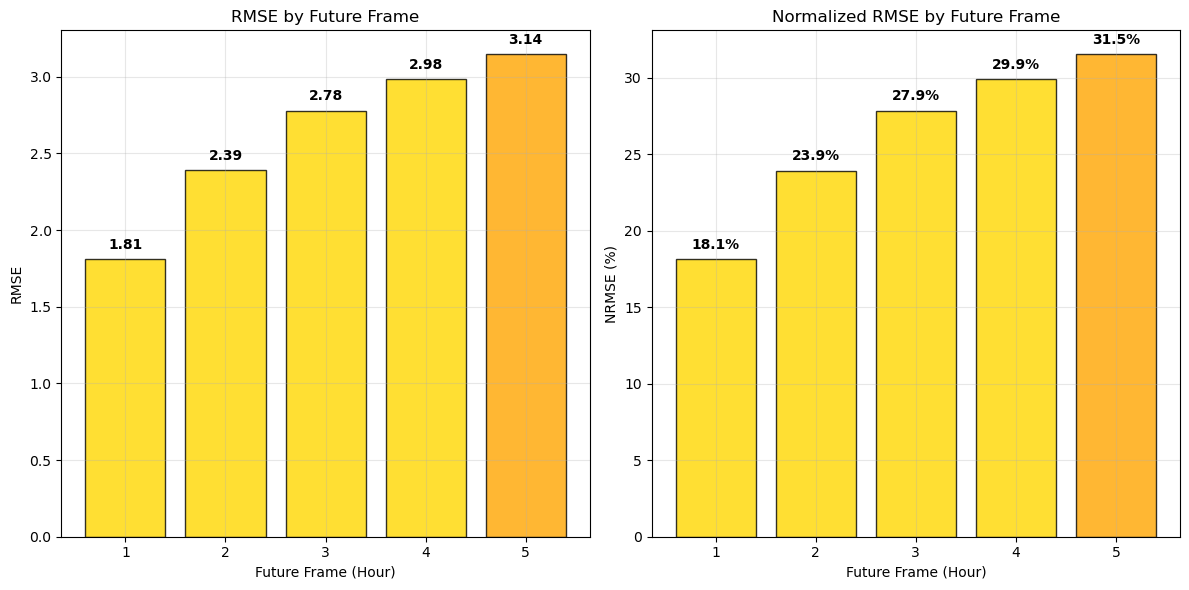


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 1.808 (18.1%)
Hour 2: RMSE = 2.388 (23.9%)
Hour 3: RMSE = 2.779 (27.9%)
Hour 4: RMSE = 2.984 (29.9%)
Hour 5: RMSE = 3.145 (31.5%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  1.808 (18.1%)   │   MAE:  1.271   │   R²:  0.845              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
──────────────

In [17]:
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



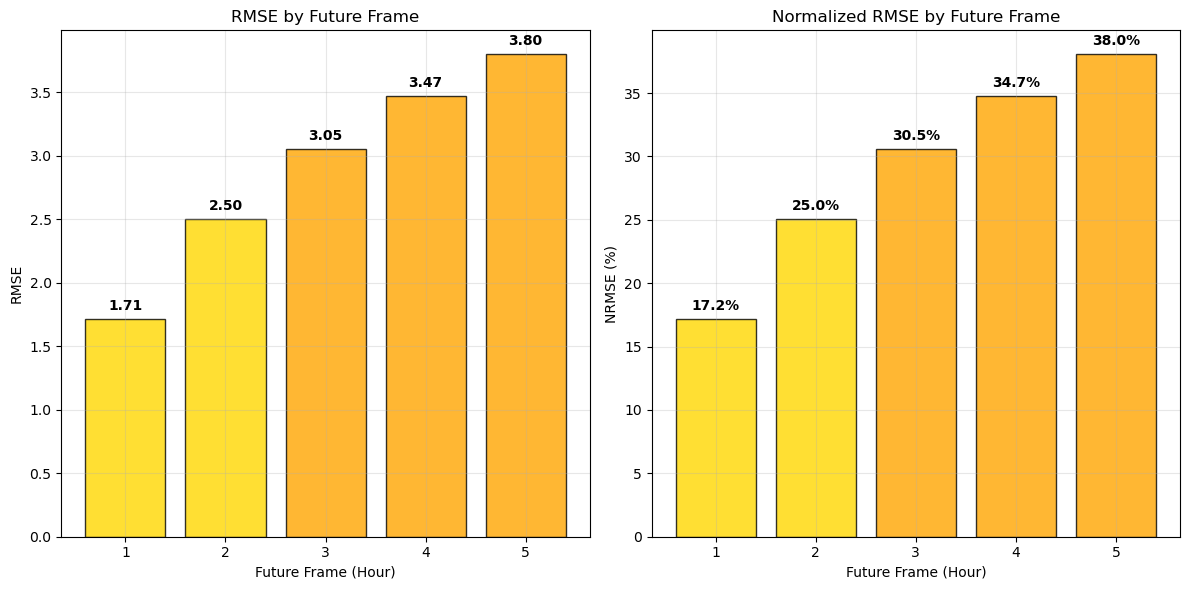


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 1.714 (17.2%)
Hour 2: RMSE = 2.498 (25.0%)
Hour 3: RMSE = 3.048 (30.5%)
Hour 4: RMSE = 3.467 (34.7%)
Hour 5: RMSE = 3.796 (38.0%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  1.714 (17.2%)   │   MAE:  1.169   │   R²:  0.861              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
──────────────

In [18]:
# new baseline; copy last 1 frames to predict next 5 frames
Y_test_copied_first_frame = np.broadcast_to(Y_test[:, 0, :][:, np.newaxis, :], Y_test.shape).copy()
plot_frame_by_frame_rmse(Y_test_copied_first_frame[:-1], Y_test[1:])
print_detailed_frame_stats(Y_test_copied_first_frame[:-1], Y_test[1:], sensor_names)

# Plots

## Snapshot plots - first frame

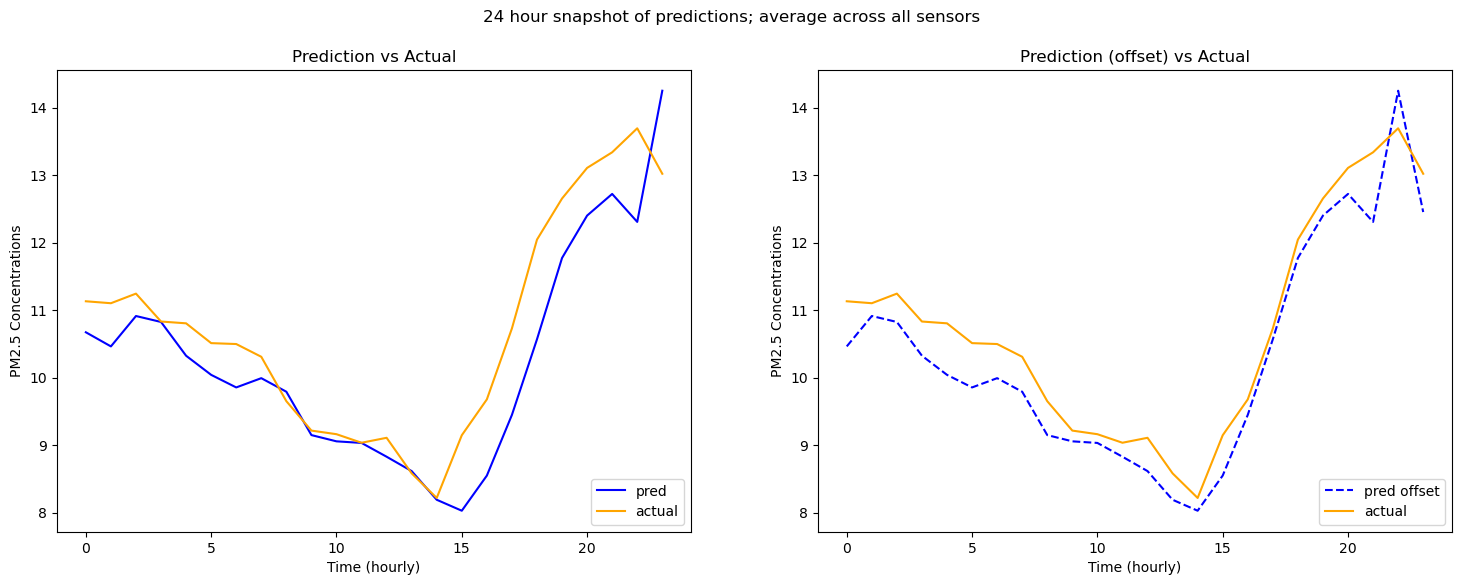

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions; average across all sensors")

axes[0].plot(y_pred_avg[1000:1024, 0], color='blue', label='pred')
axes[0].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred_avg[1001:1025, 0], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

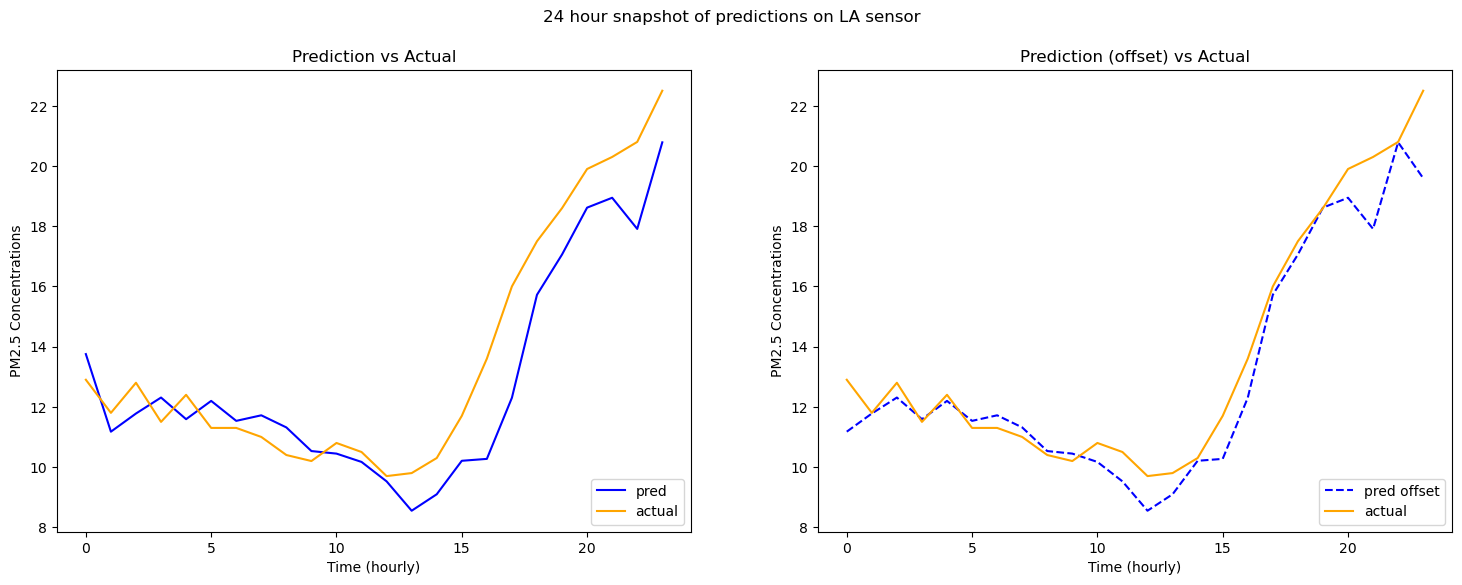

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions on LA sensor")

axes[0].plot(y_pred[1000:1024, 0, 4], color='blue', label='pred')
axes[0].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred[1001:1025, 0, 4], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

[]

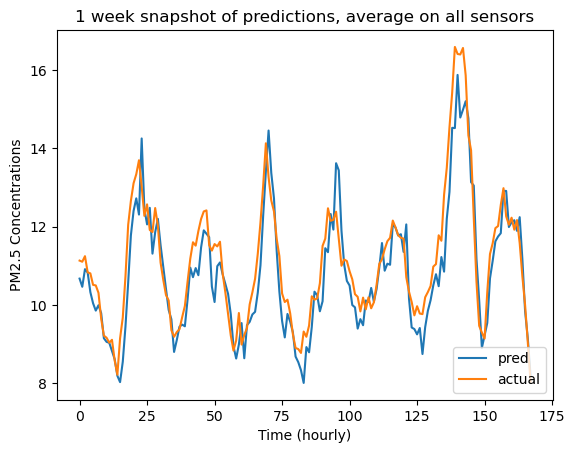

In [21]:
plt.plot(y_pred_avg[1000:1168, 0], label='pred')
plt.plot(Y_test_avg[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, average on all sensors")
plt.legend(loc="lower right")
plt.plot()

[]

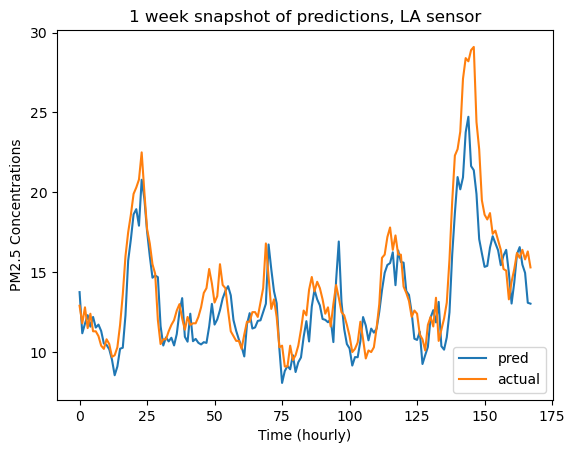

In [22]:
plt.plot(y_pred[1000:1168, 0, 4], label='pred')
plt.plot(Y_test[1000:1168, 0, 4], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, LA sensor")
plt.legend(loc="lower right")
plt.plot()

In [23]:
# best/worst if all stations are averaged into one
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

for i in range(len(y_pred) - 168):
    err = nrmse(y_pred_avg[i:i+168, 0], Y_test_avg[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i
print(best_idx, worst_idx)

2131 1816


In [24]:
dates = pd.date_range(START_DATE, END_DATE, freq='h')
y_test_start_idx = len(Y_valid)
y_test_end_idx = len(Y_valid) + len(Y_test)
print(dates[y_test_start_idx], dates[y_test_end_idx])

2024-03-19 14:00:00 2024-07-07 05:00:00


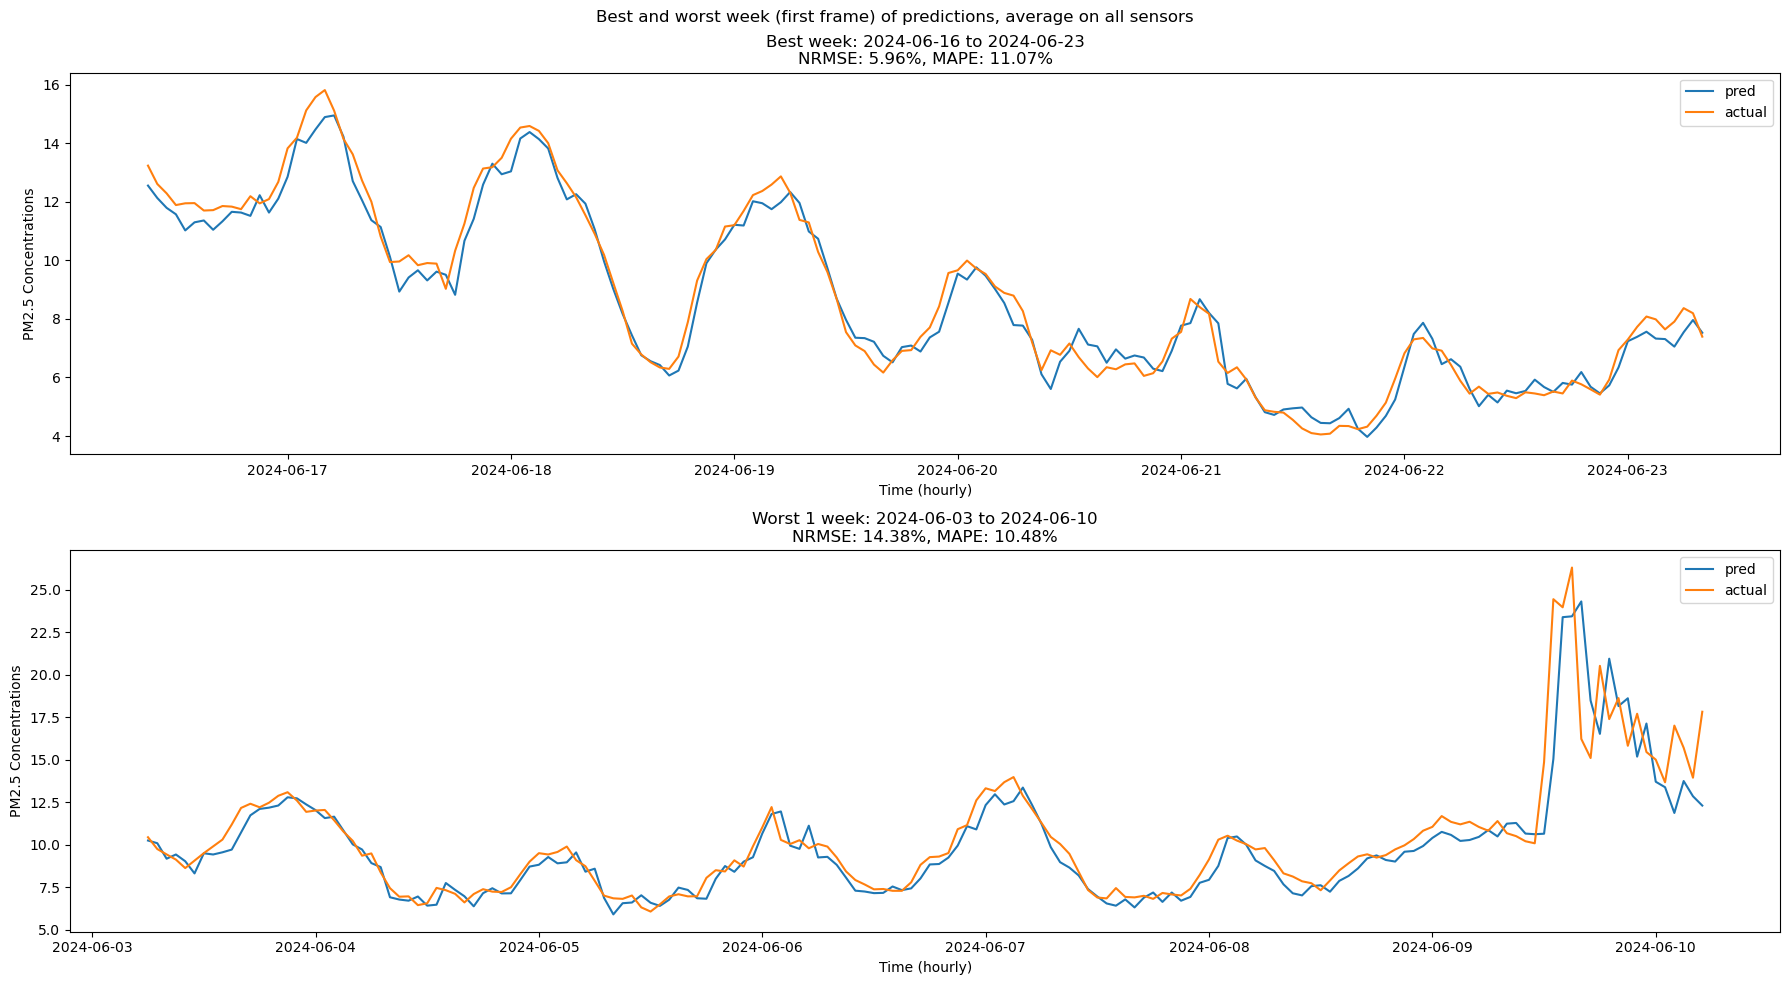

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions, average on all sensors')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    y_pred_avg[best_idx:best_idx+168, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    Y_test_avg[best_idx:best_idx+168, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[best_idx : best_idx + 168]), 
        np.squeeze(y_pred_avg[best_idx : best_idx + 168])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    y_pred_avg[worst_idx:worst_idx+168, 0], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    Y_test_avg[worst_idx:worst_idx+168, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[worst_idx : worst_idx + 168]), 
        np.squeeze(y_pred_avg[worst_idx : worst_idx + 168])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [26]:
# best/worst of an individual sensor
best_week_sensor = float('inf')
worst_week_sensor = float('-inf')
best_sensor, worst_sensor = -1, -1
best_idx_sensor, worst_idx_sensor = 0, 0
for i in range(len(y_pred) - 168):
    for j in range(len(sensor_names)):
        err = nrmse(y_pred[i:i+168, 0, j], Y_test[i:i+168, 0, j])
        if err < best_week_sensor:
            best_week_sensor = err
            best_idx_sensor = i
            best_sensor = j
        if err > worst_week_sensor:
            worst_week_sensor = err
            worst_idx_sensor = i
            worst_sensor = j
print(best_idx_sensor, best_sensor, worst_idx_sensor, worst_sensor)

1546 5 2336 6


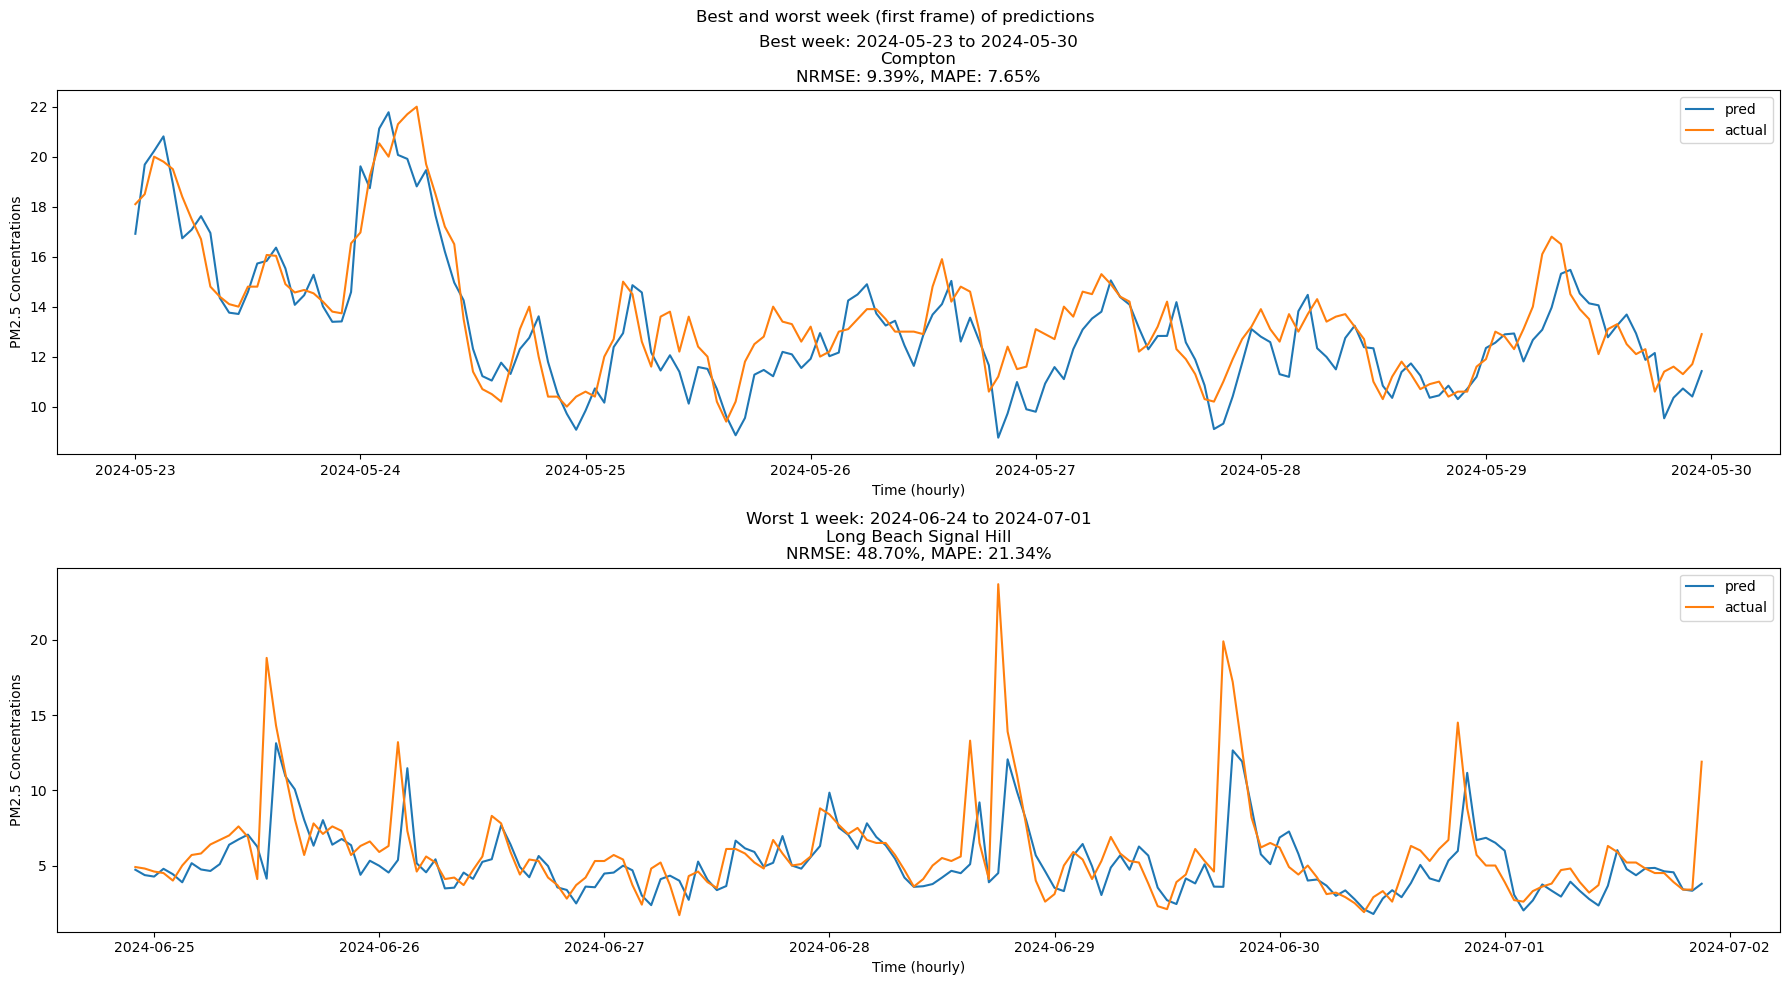

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    y_pred[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    Y_test[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[best_sensor]}\n"
    f"NRMSE: {best_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor]), 
        np.squeeze(y_pred[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    y_pred[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    Y_test[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[worst_sensor]}\n"
    f"NRMSE: {worst_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_sensor : worst_idx_sensor + 168, 0, worst_sensor]), 
        np.squeeze(y_pred[worst_idx_sensor: worst_idx_sensor + 168, 0, worst_sensor])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Rolling avg plots

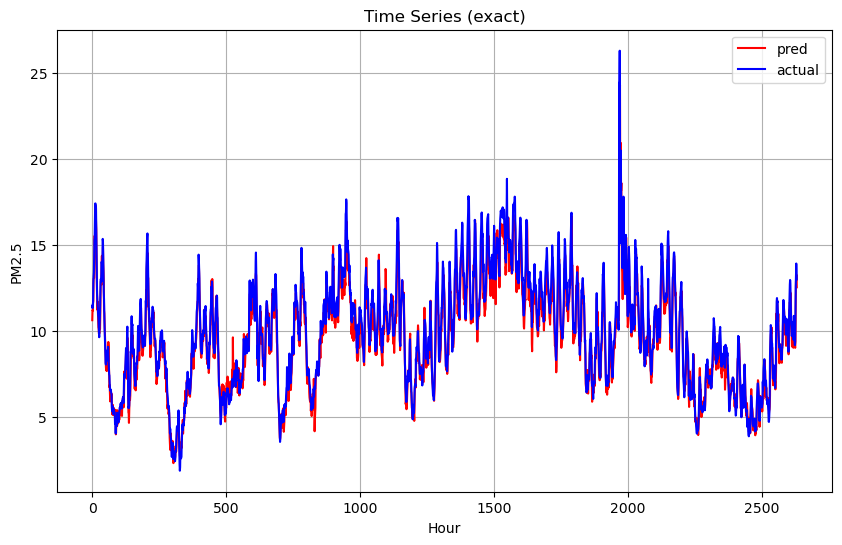

In [28]:
series_pred = pd.Series(np.squeeze(y_pred_avg[:, 0]))
series_test = pd.Series(np.squeeze(Y_test_avg[:, 0]))

plt.figure(figsize=(10, 6))
plt.plot(series_pred, label=f'pred', color='red')
plt.plot(series_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

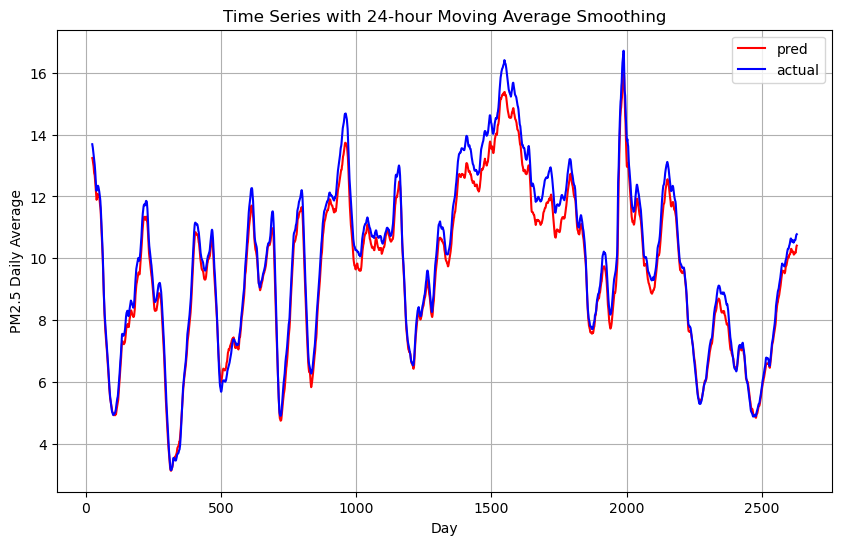

In [29]:
import pandas as pd

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

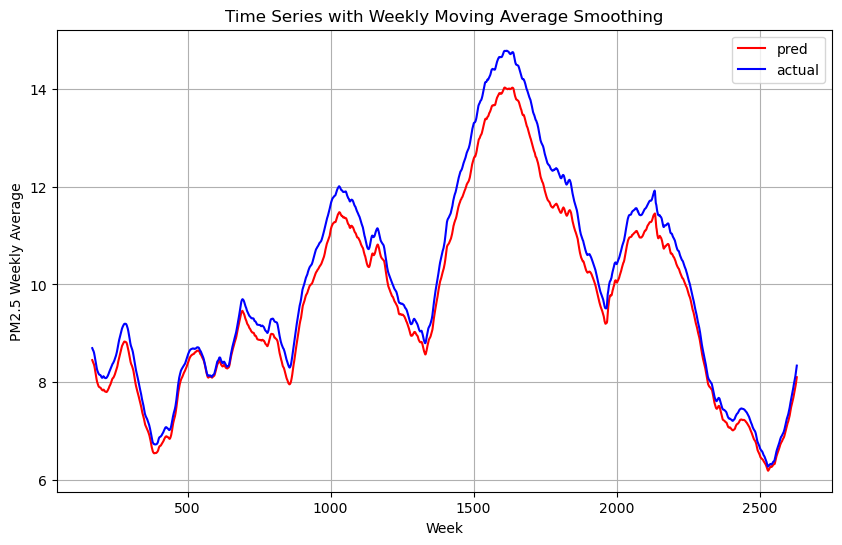

In [30]:
window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

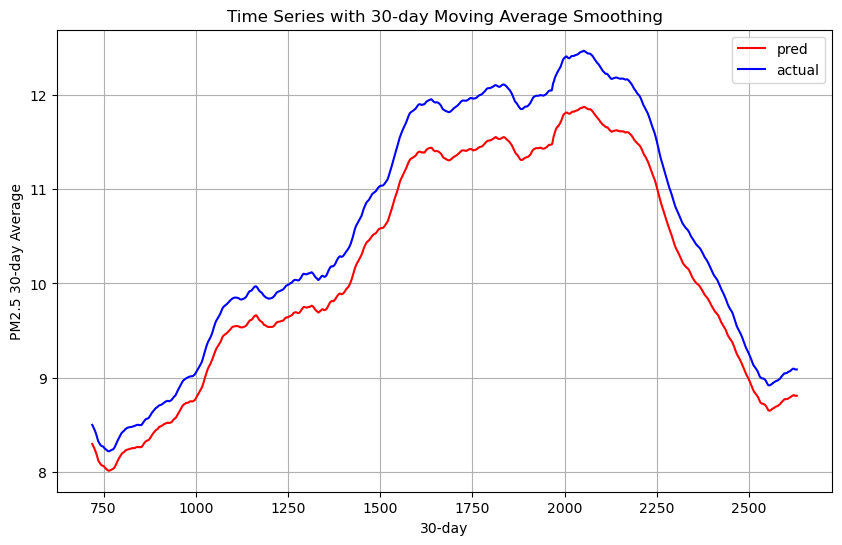

In [31]:
window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

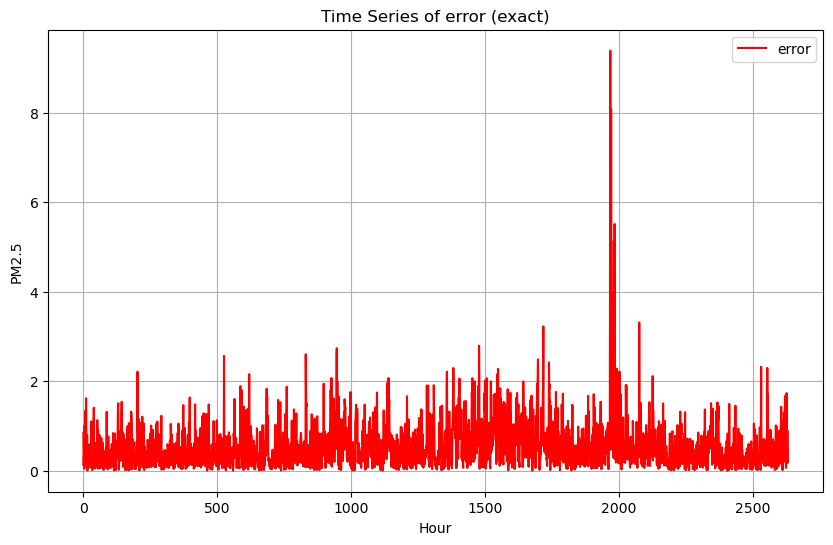

In [32]:
series = pd.Series(np.squeeze(np.abs(y_pred_avg[:, 0] - Y_test_avg[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

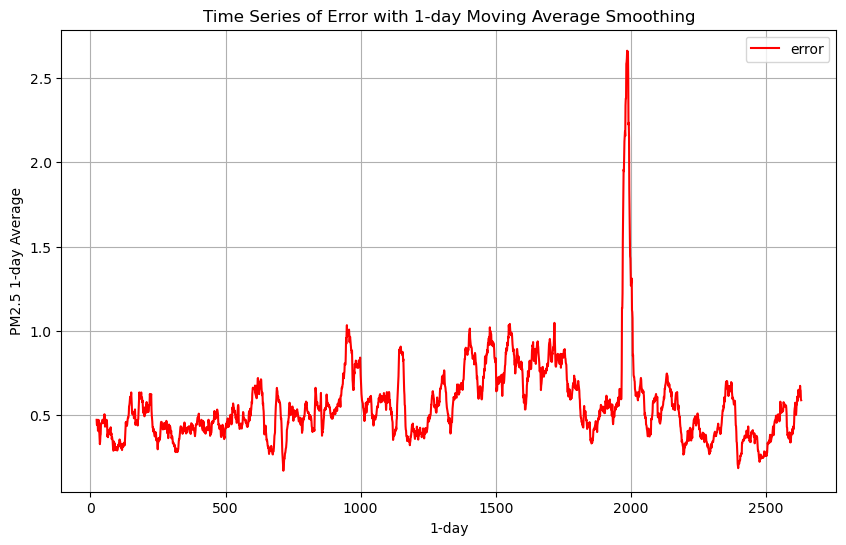

In [33]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

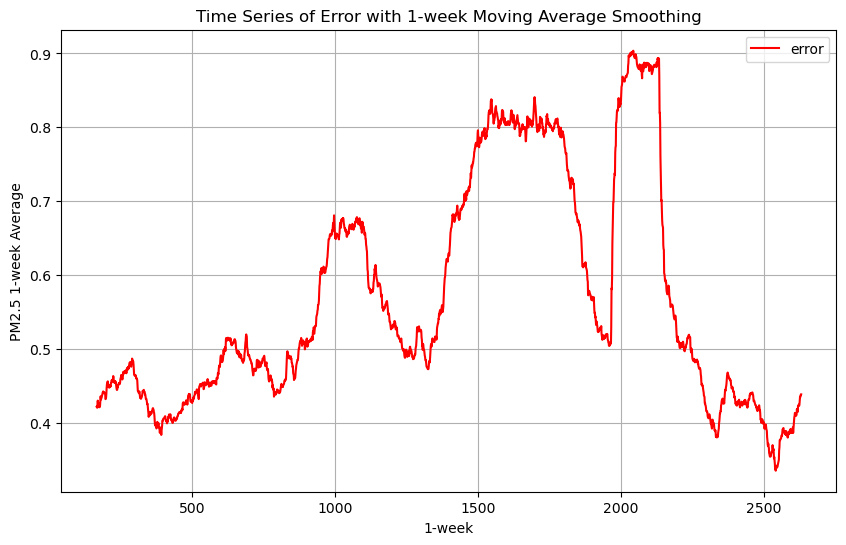

In [34]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

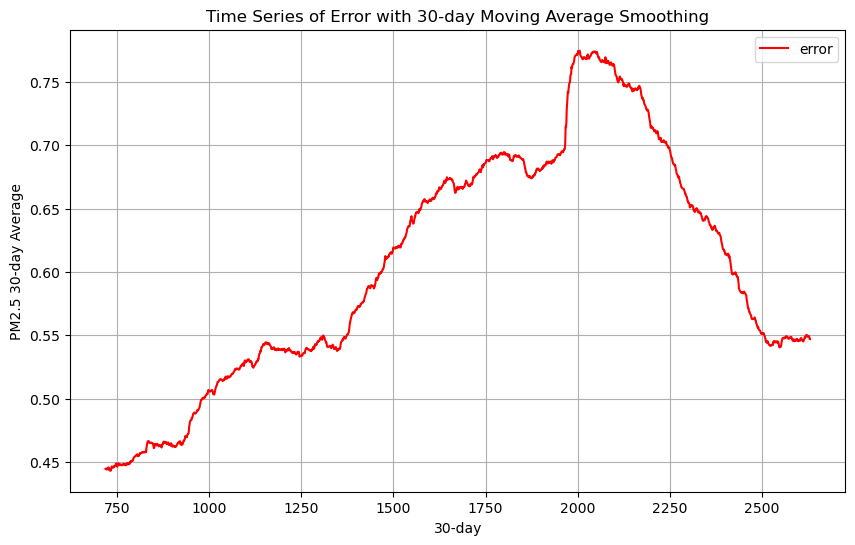

In [35]:
window_size = 720 # 30-day average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()